In [3]:
import sys,os
sys.path.append(os.path.abspath("../"))
sys.path.append(os.path.abspath('../modules/'))

import healpy as h
import multiprocessing as mp
from modules.settings import global_mmf_settings as gset
from data_preprocess import tiling_the_sphere as tts
from data_preprocess import tile_planck_data as tpd
from filters import modular_multi_matched_filter as mmf
from simulate import cluster_templates as cltemp

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [4]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

outpath="/results/" + dataset + "/planck_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_tiles/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=15.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
datapath=gset.mmfset.paths["result_data"]

/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


<IPython.core.display.Javascript object>


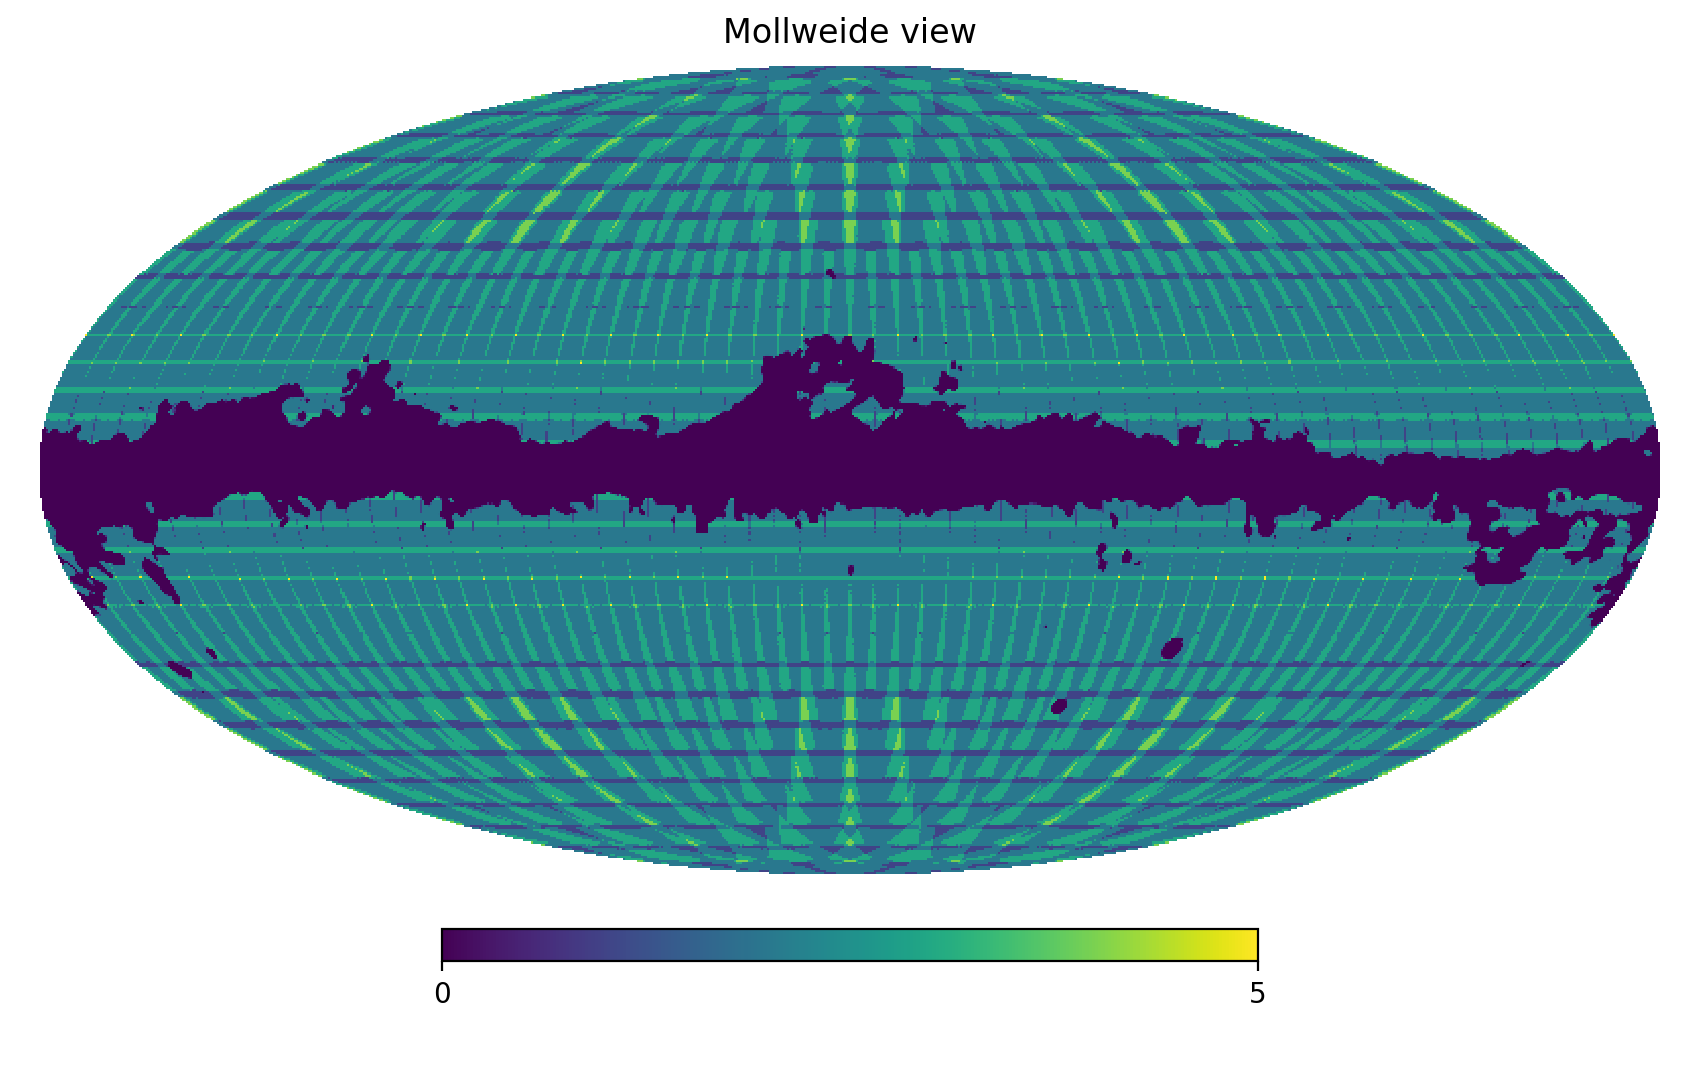

In [5]:
tile_map,fsky_map,apo_mask=tts.return_sky_tile_map()
tiledef=tpd.get_tangent_plane_fnames(fsky_map=fsky_map,fsky_thr=0.3)
h.mollview(tile_map)
filename=figpath + "tile_the_sky.pdf"
plt.savefig(filename,bbox_inches="tight",dpi=200)

In [4]:
# tpd.extract_data_tiles(tiledef)

# def gen_ps_inpainted_data(px):
#     tpd.gen_ps_inpainted_data(px,tiledef)
    
# def parallel_psfill(numprocs):
#     pool=mp.Pool(processes=numprocs)
#     pool.map(gen_ps_inpainted_data,tiledef.keys())
#     pool.close()
#     pool.join()
    
# start=time.time()
# parallel_psfill(4)
# print time.time()-start

In [6]:
from automated_detection import extract_tile_cluster_catalogue_v1 as etcc

In [7]:
tmplt=cltemp.cluster_spectro_spatial_templates(T_step=1.,theta500_min=1.,theta500_max=100.,theta_step=2.)
tmplt.setup_templates()

In [8]:
def wrap_extract_tile_cluster_catalogue(px):
    x=etcc.extract_tile_cluster_catalogue(px,tiledef,tmplt,genfig=True)

def parallel_etcc(numprocs):
    pool=mp.Pool(processes=numprocs)
#    pool.map(wrap_extract_tile_cluster_catalogue,tiledef.keys())
    pool.map_async(wrap_extract_tile_cluster_catalogue,tiledef.keys())
    pool.close()
    pool.join()

# start=time.time()
# parallel_etcc(32)
# print time.time()-start

In [9]:
start=time.time()
cat,fildata=etcc.extract_tile_cluster_catalogue(238,tiledef,tmplt,genfig=True,remove_sz=False)
print time.time()-start

323.705203056


In [35]:
from astropy.io import fits

f=fits.open(tiledef[238]["FILENAME"])

<IPython.core.display.Javascript object>


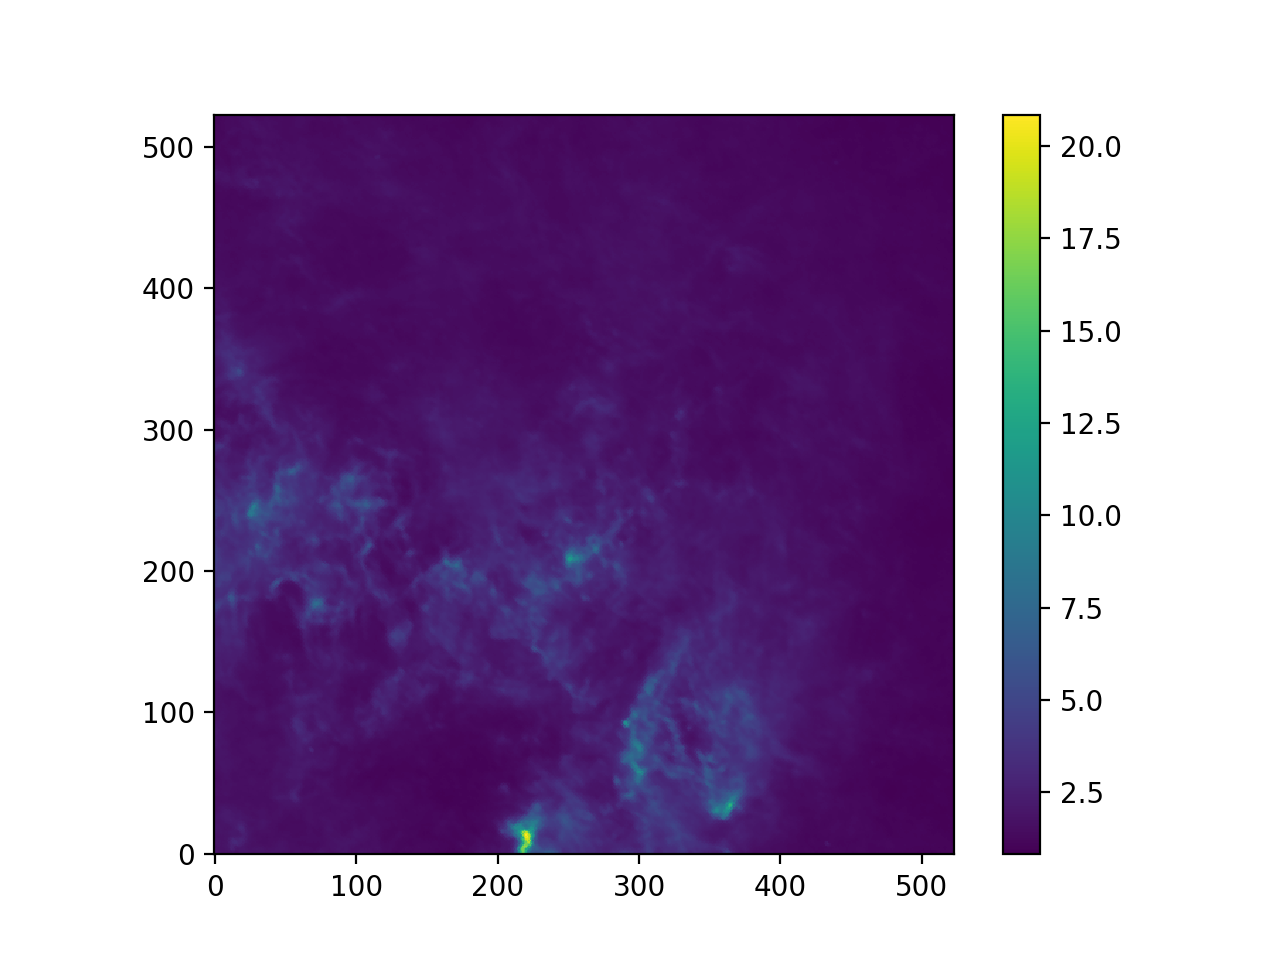

In [42]:
figure()
imshow(f[2].data[8,:]/std(f[2].data[8,:]),origin="lower")
colorbar()

<IPython.core.display.Javascript object>


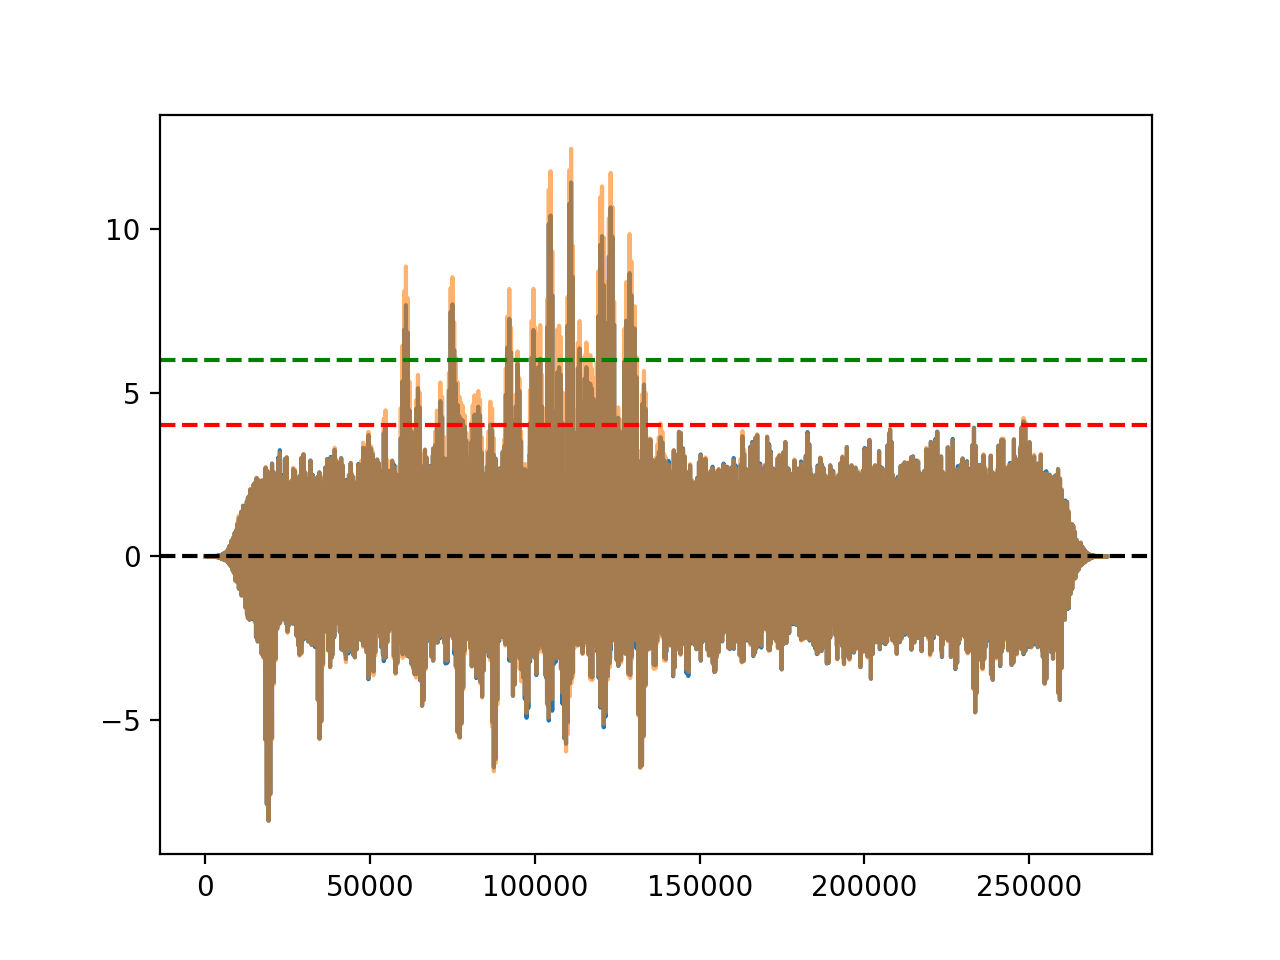

9.183272638686697e-05
9.049044758173864e-05


In [10]:
ion()
figure()
idx=50
th=cat["theta500"][idx]
err=cat["err_yc"][idx] ; print err
err1=cat["err_yc_rev"][idx] ; print err1
plot(fildata["iter0"][th].ravel()/err)
plot(fildata["iter1"][th].ravel()/err1,alpha=0.6)
axhline(0,linestyle="dashed",color="k")
axhline(4,linestyle="dashed",color="r")
axhline(6,linestyle="dashed",color="g")

<IPython.core.display.Javascript object>


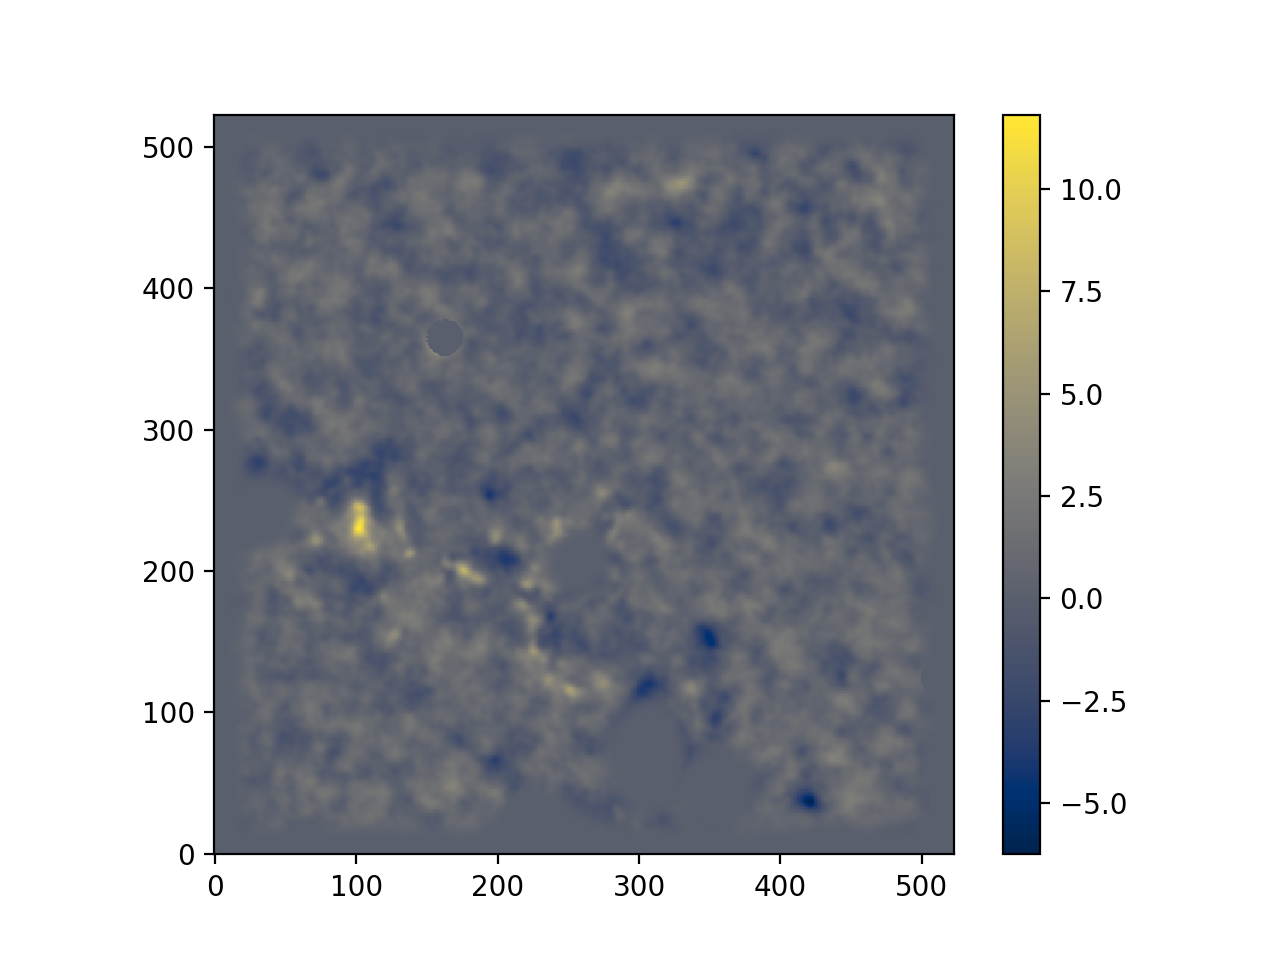

In [34]:
thc=29.
idx=np.where(cat["theta500"]==thc)[0][0]
err=cat["err_yc_rev"][idx]
figure()
imshow(fildata["iter1"][thc]/err,origin="lower",cmap="cividis")
colorbar()

In [28]:
max(fildata["iter0"][thc].ravel()/err)

6.426451816253636

In [13]:
from modules.flat_sky_codes import tangent_plane_analysis as tpa

glon,glat=h.pix2ang(8,cat["pix"],lonlat=True)
projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
mfcm=etcc.return_cluster_model(cat["cat"],snrthr=4,projop=projop)

In [11]:
dist=np.zeros((len(cat["cat"].keys()),len(cat["cat"].keys())))
for i in cat["cat"].keys():
    for j in cat["cat"].keys():
        dist[i,j]=etcc.return_distance(cat["cat"][i]["mp_gal_coord"],cat["cat"][j]["mp_gal_coord"])

In [14]:
for i in cat["cat"].keys():
    print sort(dist[i,:])

[  0.          29.94536729  30.86645589  49.54947973  53.38164839
  56.38149886  61.78808527  67.32502954  88.80127107 100.61855826
 106.25085795 116.33981879 135.3349759  136.69732684 164.9258439
 215.08134743 219.22237915 230.81263078 238.37704773 239.98107705
 259.54589994 292.4536928  297.70841452 317.8321025  321.42455875
 326.1245611  351.2833955  446.7595295  461.28124329 571.48730463]
[  0.          29.91698579  41.68527847  63.01391369  94.99162452
 117.29620622 136.79340374 147.29192705 153.72058918 185.3805877
 193.02530594 202.84970027 203.15484819 222.27765855 222.60116358
 239.88102971 252.03865869 255.44252986 283.70407955 293.78490674
 321.42455875 322.99902848 324.5991682  342.35763586 344.52850095
 355.27010438 365.91512643 377.76790165 437.15055495 627.71674999]
[  0.         172.90109291 203.85016442 215.48666253 226.67787568
 230.81263078 235.39653748 244.11274637 249.23350437 250.81826261
 262.8869495  264.37640864 268.69666127 300.36285628 301.79529091
 303.12658

<IPython.core.display.Javascript object>


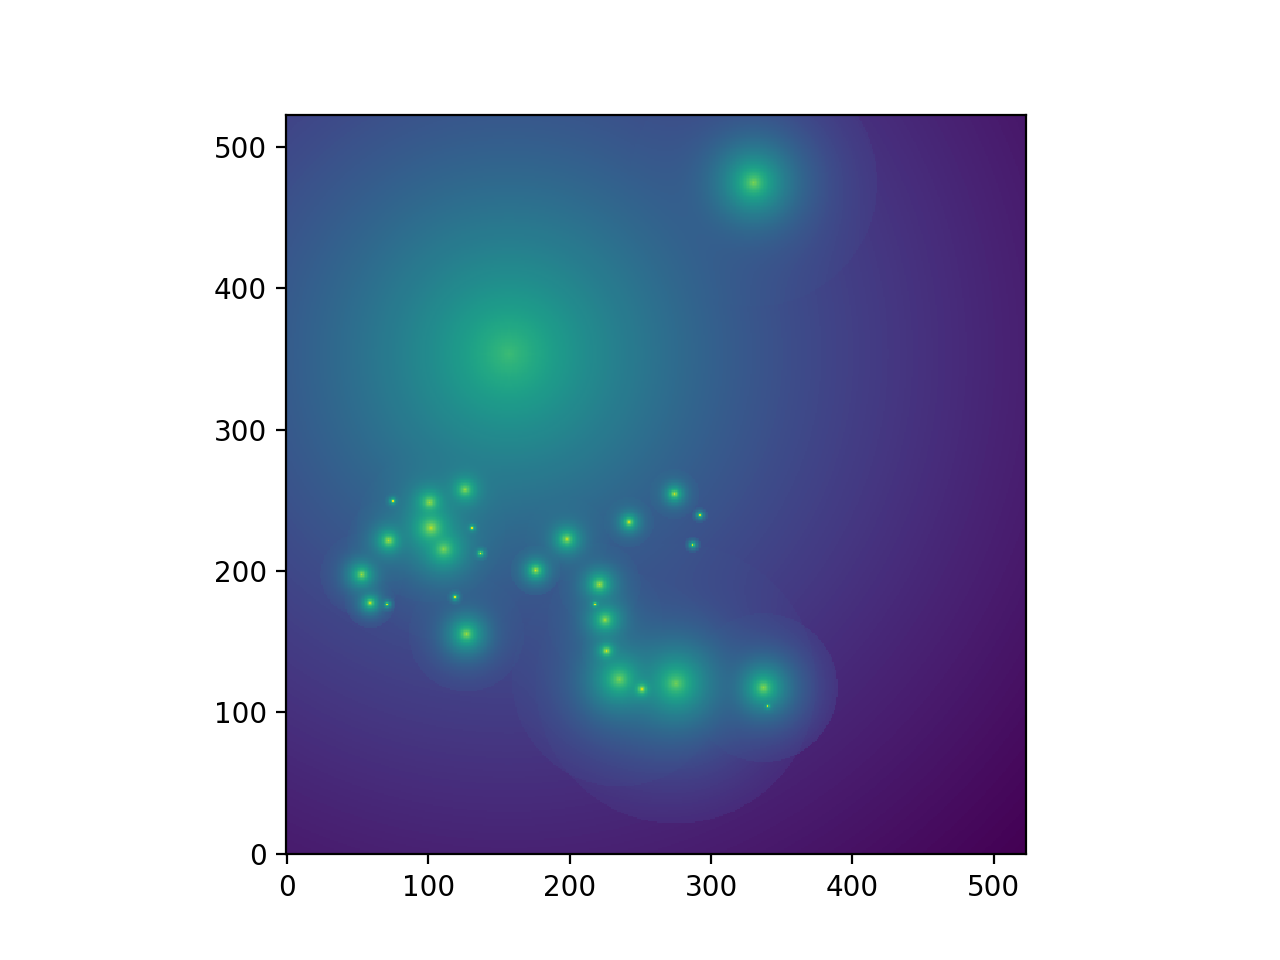

In [14]:
figure()
imshow(log10(mfcm),origin="lower")

In [53]:
for px in cat["cat"].keys():
    print cat["cat"][px]["mp_thetac"],cat["cat"][px]["mp_snr"]

9.0 10.896983548217651
3.0 7.85383509938395
101.0 4.078317789892776
15.0 5.249151848679067
3.0 10.55726788531919
1.0 11.40888167859595
3.0 7.722146501813051
3.0 6.029263819089955
5.0 6.327023436530521
5.0 5.930578262697526
9.0 4.741467975542758
17.0 4.446897974529486
3.0 5.329111417827377
3.0 7.016626202381858
1.0 6.719292926152491
7.0 4.626391638721337
5.0 9.114569932105722
5.0 5.484425957625087
3.0 6.383567747543074
1.0 5.869485335289465
7.0 4.395698611686851
1.0 7.246445104000372
1.0 6.9546929610662565
5.0 4.351138061824344
5.0 6.286112841817153
3.0 4.432044106825931
1.0 5.770771351342921
3.0 4.398117779434851
7.0 4.0678371949649295
1.0 4.648796475895217
1.0 4.738320473851918
1.0 4.567145710196178
1.0 4.369696713331268
1.0 4.229849083348288
3.0 4.00943191276642
1.0 4.008764168986024
1.0 4.002335854209847


In [48]:
cat["fsky"]

0.8288125272904842